In [267]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [268]:
import sys
sys.path.append(r'../')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [269]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartrition/output_repar_test1/'

In [270]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartrition/output_repar_test1/


In [271]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [272]:
info_basic

{'Fs': 500,
 'd_end': 159,
 'd_len': 31,
 'd_start': 128,
 'dir_disp': 'disppick_test1/',
 'dir_ds': 'ds_test1/',
 'dir_image': 'image_test1/',
 'dir_stack': 'stack_test1/',
 'fftlen': 150000,
 'flag_accept': 0.4,
 'flag_c': [0.35, 0.75],
 'flag_f': [10, 15],
 'flag_onebit': 0,
 'flag_prewhiten': 1,
 'fstride': 8.0,
 'key_subworks': ['07-03--1',
  '09-03--2',
  '10-03--3',
  '11-03--4',
  '12-03--5',
  '13-03--6',
  '14-03--7',
  '15-03--8',
  '16-03--9',
  '17-03--10',
  '18-03--11',
  '19-03--12',
  '21-03--13',
  '22-03--14',
  '23-03--15',
  '24-03--16',
  '25-03--17',
  '29-03--18',
  '30-03--19',
  '32-03--20',
  '33-03--21',
  '34-03--22',
  '36-03--23',
  '37-03--24',
  '38-03--25',
  '39-03--26',
  '40-03--27',
  '42-03--28',
  '43-03--29',
  '44-03--30',
  '45-03--31',
  '46-03--32',
  '47-03--33',
  '48-03--34',
  '50-03--35',
  '51-03--36',
  '52-03--37',
  '53-03--38',
  '07-04--39',
  '08-04--40',
  '10-04--41',
  '11-04--42',
  '12-04--43',
  '13-04--44',
  '14-04--45',


In [273]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [274]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [275]:
probes = info_basic_probes['key_subworks']
key_subworks = info_basic_targets['key_subworks']

In [276]:
dir_image = dir_project+info_basic['dir_image']
dir_disp  = dir_project + info_basic['dir_disp'] 
print('dir_image: ', dir_image)
print('dir_disp: ', dir_disp)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartrition/output_repar_test1/image_test1/
dir_disp:  /shdisk/rem2/Harmon/F-J/San/project_repartrition/output_repar_test1/disppick_test1/


### Pick probes' Phase velocity automatically

In [277]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [278]:
def smooth_data(data, window_size=3):
    """
    使用移动平均平滑数据。

    Parameters:
    - data: 输入的数据列表
    - window_size: 移动窗口的大小，默认为3

    Returns:
    - 平滑后的数据列表
    """
    smoothed_data = []

    for i in range(len(data)):
        start_index = max(0, i - window_size // 2)
        end_index = min(len(data), i + (window_size + 1) // 2)

        # 计算窗口内数据的平均值
        window_average = sum(data[start_index:end_index]) / (end_index - start_index)

        smoothed_data.append(window_average)

    return smoothed_data

In [279]:
def pick_velocity(key_subwork):
    global f
    global c
    global info_basic
    global info_basic_probes
    global info_basic_targets
    global flag_f
    global flag_c
    global dir_project
    global dir_peoject_probes
    global dir_disp

    grace = 0.02

    dir_ds_probes = dir_project_probes + info_basic_probes['dir_ds']
    ds = h5py.File(dir_ds_probes+'ds_'+key_subwork+'.h5', 'r')

    ds_remove = ds['ds_remove'][0]
    f_sample = []
    c_sample = []

    f_new = f[np.logical_and(f>flag_f[0],f < flag_f[1])]
    c_new = c[np.logical_and(c>flag_c[0],c < flag_c[1])]

    # Three samples
    f0 = flag_f[0]
    f1 = (flag_f[0] + flag_f[1])/3
    f2 = flag_f[1]
    c0 = c_new[np.argmax(ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),f==find_nearest(f,f0)])]
    c1 = c_new[np.argmax(ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),f==find_nearest(f,f1)])]
    c2 = c_new[np.argmax(ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),f==find_nearest(f,f2)])]

    ds_new0 = ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),:]
    ds_new = ds_new0[:,np.logical_and(f>flag_f[0],f < flag_f[1])]   
    

    for index_f in range(len(f_new)):
        #print(index_f)
        if f_new[index_f] >= f0 and f_new[index_f] < f1:
            slope = (c1-c0)/(f1-f0)
            #index_c = np.where(ds_new[:,index_f] == np.max(ds_new[c_new<c0+slope*(f_new[index_f]-f0)+grace,index_f] ))[0][0]
            index_c = np.argmax(ds_new[c_new<c0+slope*(f_new[index_f]-f0)+grace,index_f])
        else:
            slope = (c2-c1)/(f2-f1)
            index_c = np.argmax(ds_new[c_new<c1+slope*(f_new[index_f]-f1)+grace,index_f])
            #index_c = np.where(ds_new[:,index_f] == np.max(ds_new[c_new[c_new<flag_c[1]*0.7]<c1+slope*(f_new[index_f]-f1)+grace,index_f] ))[0][0]
        f_sample.append(f_new[index_f])
        c_sample.append(c_new[index_c])
    
    c_sample = smooth_data(c_sample, window_size=1)

    f_smooth = np.linspace(min(f_sample), max(f_sample), 40)  # np.linspace 等差数列,从x.min()到x.max()生成300个数，便于后续插值
    c_smooth = make_interp_spline(f_sample, c_sample)(f_smooth)
    # 写入txt文件
    np.savetxt(dir_disp+'autopick_'+key_subwork+'.txt', np.array([f_smooth,c_smooth]).T, fmt='%.2f', delimiter=',')
    print('finish '+ key_subwork)
    #return ds_remove, f_smooth, c_smooth,f0,f1,f2,c0,c1,c2


In [280]:
f = info_basic_bi_probes['f']
c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])

In [281]:
flag_c = [0.35,0.75]
flag_f = [10,15]
nThreads = 5
c_mean = {}
c_mean_data = np.zeros(len(f))
flag_pick = 1
flag_plot = 0

In [282]:
nThreads = 20
if flag_pick == 1:
    pool = ThreadPoolExecutor(max_workers = nThreads)
    for probe in probes:
        pool.submit(pick_velocity,probe)
    pool.shutdown()

finish 06-02
finish 04-02
finish 08-02
finish 05-02
finish 21-02
finish 19-02
finish 18-02
finish 17-02
finish 16-02
finish 07-02
finish 24-02
finish 11-02
finish 10-02
finish 12-02
finish 15-02
finish 20-02
finish 14-02
finish 22-02
finish 09-02
finish 23-02
finish 30-02
finish 27-02
finish 35-02
finish 31-02
finish 33-02
finish 25-02
finish 13-02
finish 26-02
finish 28-02
finish 29-02
finish 40-02
finish 41-02
finish 37-02
finish 44-02


finish 43-02
finish 45-02
finish 42-02
finish 36-02
finish 34-02
finish 46-02
finish 38-02
finish 48-02
finish 50-02
finish 49-02
finish 47-02
finish 06-03
finish 51-02
finish 53-02
finish 52-02
finish 08-03
finish 54-02
finish 05-03
finish 13-03
finish 04-03finish 55-02

finish 11-03
finish 10-03
finish 17-03
finish 07-03
finish 15-03
finish 18-03
finish 16-03
finish 32-02
finish 57-02
finish 09-03
finish 12-03
finish 39-02
finish 19-03
finish 14-03
finish 23-03
finish 21-03
finish 22-03
finish 27-03
finish 24-03
finish 56-02
finish 37-03
finish 26-03
finish 33-03
finish 25-03
finish 35-03
finish 29-03
finish 36-03
finish 28-03
finish 32-03
finish 42-03
finish 30-03
finish 40-03
finish 38-03
finish 43-03
finish 46-03
finish 50-03
finish 41-03
finish 49-03
finish 53-03
finish 45-03
finish 56-03
finish 34-03
finish 51-03
finish 31-03
finish 54-03
finish 47-03
finish 20-03
finish 39-03
finish 55-03
finish 48-03
finish 04-04
finish 07-04
finish 44-03
finish 06-04
finish 11-04
finish 09-04

### Plot to see pick results

In [283]:
def plot_disp(key_subwork):
    global dir_disp_probes
    global dir_disp
    global f
    global c

    fig,ax = plt.subplots(1,1,figsize=(8,6))
    dir_ds_probes = dir_project_probes + info_basic_probes['dir_ds']
    ds = h5py.File(dir_ds_probes+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]

    title0 = key_subwork
    ax = plotlib.plot_fj(ax,ds_remove,title0,f,c,0,c_map='jet')

    f_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,1]
    ax.scatter(f_pick,c_pick,marker='o',s=10,color='k')
    plt.savefig(dir_image+'autopick_'+key_subwork+'.png',dpi=60)
    plt.close()
    print('finish '+key_subwork)


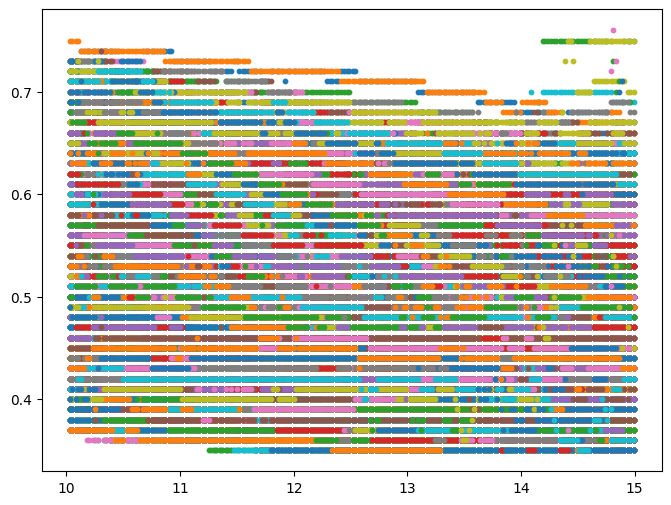

In [284]:

fig,ax = plt.subplots(1,1,figsize=(8,6))
for probe in probes:
    f_pick = np.loadtxt(dir_disp+'autopick_'+probe+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+probe+'.txt',delimiter=',')[:,1]
    ax.scatter(f_pick,c_pick,marker='o',s=10)


In [285]:
if flag_plot == 1:
    for probe in probes:
        plot_disp(probe)


### calculate K-S value to see the result

In [286]:
def loc_key(key_subwork):
    global stalist_all
    global lat_all
    global lon_all
    key = 'R'+key_subwork[0:2]+key_subwork[3:]
    if key in stalist_all:
        lat_this = lat_all[stalist_all.index(key)]
        lon_this = lon_all[stalist_all.index(key)]
    else:
        key1 = 'R' + str(int(key_subwork[0:2])-1).zfill(2)+key_subwork[3:5]
        key2 = 'R' + str(int(key_subwork[0:2])+1).zfill(2)+key_subwork[3:5]
        indx1 = stalist_all.index(key1)
        indx2 = stalist_all.index(key2)
        lat_this= (lat_all[indx1]+lat_all[indx2])/2
        lon_this = (lon_all[indx1]+lon_all[indx2])/2
    return lon_this,lat_this

In [287]:
def extract_probes(key_subwork):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stainfo_targets

    stas = stainfo_targets[key_subwork]['Station'].tolist()
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [288]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [289]:
stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes = pd.read_excel(stalistname,sheet_name=None)
stalistname = dir_project_targets+ info_basic_targets['stalistname']
stainfo_targets = pd.read_excel(stalistname,sheet_name=None)

In [290]:
def calculate_centroid(coordinates):
    return np.mean(coordinates, axis=0)

In [291]:
def repartrition(key_subwork):
    global dir_image
    global dir_project
    global stainfo_probes
    global stainfo_targets
    global flag_c
    global flag_accept
    global lat_all
    global lon_all
    global stalist_all
    global flag_plot
    global lon_centroid_all
    global lat_centroid_all
    global stations_accept_all
    
    probes_this = extract_probes(key_subwork)
    stations = set()
    for probe in probes_this:
        stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
        stations = stations.union(set(stations_this))
        
    stations = list(stations)
    lats = [lat_all[stalist_all.index(station)] for station in stations]
    lons = [lon_all[stalist_all.index(station)] for station in stations]

    lon_this = []
    lat_this = []
    for probe in probes_this:
        lon,lat = loc_key(probe)
        lon_this.append(lon)
        lat_this.append(lat)
    # 读取全部autopick dispersion curves
    disp_all = {}
    f_sample = np.array([])
    for probe in probes_this:
        file_ds = dir_project  + info_basic['dir_disp'] + 'autopick_'+probe+'.txt'
        if f_sample.size == 0:
            f_sample = np.loadtxt(file_ds,delimiter=',')[:,0]
            c_all = np.zeros([len(probes_this),len(f_sample)])
        disp_all[probe] = np.loadtxt(file_ds,delimiter=',')[:,1]
        c_all[probes_this.index(probe)] = disp_all[probe]
    
    # 计算平均值
    c_mean = []
    c_median = []
    for i in range(len(f_sample)):
        data = c_all[:,i]
        mean_value = np.mean(data)
        std_dev = np.std(data)
        threshold = 0.7  # 根据需要调整阈值
        outliers = [value for value in data if abs(value - mean_value) > threshold * std_dev]
        # 移除异常值
        cleaned_data = [value for value in data if value not in outliers]
        # 计算修正后的平均值
        trimmed_mean = np.mean(cleaned_data)
        #median = np.median(data)
        c_mean.append(trimmed_mean)
    # 对c_mean做平滑
    c_mean = smooth_data(c_mean, window_size=30)    
    
    # 计算k-S度量值
    ks_p_values = []
    ks_statistic = []
    for probe in probes_this:
        ks_statistic.append(ks_2samp(disp_all[probe],c_mean)[0])
        ks_p_values.append(ks_2samp(disp_all[probe],c_mean)[1])

    index_accept = np.array(ks_statistic)<flag_accept
    probe_accept = np.array(probes_this)[index_accept]

    # calculate all stations and accepted stations
    stations_this_all = set()
    for probe in probes_this:
        stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
        stations_this_all = stations_this_all.union(set(stations_this))
    stations_this_all = list(stations_this_all)
    lat_this_all = [lat_all[stalist_all.index(station)] for station in stations_this_all]
    lon_this_all = [lon_all[stalist_all.index(station)] for station in stations_this_all]
    stations_accept = set()
    for probe in probe_accept:
        stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
        stations_accept = stations_accept.union(set(stations_this))
    stations_accept = list(stations_accept)
    lat_accept = [lat_all[stalist_all.index(station)] for station in stations_accept]
    lon_accept = [lon_all[stalist_all.index(station)] for station in stations_accept]

    # calculate centroid
    lon_centroid,lat_centroid = calculate_centroid(np.array([lon_accept,lat_accept]).T)
    stations_accept_all[key_subwork] = stations_accept
    lon_centroid_all[key_subwork] = lon_centroid
    lat_centroid_all[key_subwork] = lat_centroid    
    print('finish '+key_subwork)
    # plot
    if flag_plot == 1:
        fig,ax = plt.subplots(2,3,figsize=(15,8))
        ax[0][0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
        for i in range(len(faults)):
            ax[0][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
        ax[0][0].scatter(stainfo_targets[key_subwork]['longitude'], stainfo_targets[key_subwork]['latitude'],marker='.',color='r',s=10)
        ax[0][0].scatter(loc_key(key_subwork)[0], loc_key(key_subwork)[1],marker='^',color='g',s=50)
        ax[0][0].axis('off')

        ax[1][0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
        for i in range(len(faults)):
            ax[1][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
            ax[1][0].scatter(lon_this, lat_this,marker='.',color='b',s=30)
            ax[1][0].scatter(lons,lats,marker='.',color='r',s=10)
        ax[1][0].scatter(loc_key(key_subwork)[0], loc_key(key_subwork)[1],marker='^',color='g',s=50)
        ax[1][0].axis('off')

        for probe in probes_this:
            ax[0][1].scatter(f_sample,disp_all[probe],marker='.',s=1)
        ax[0][1].plot(f_sample,c_mean,linestyle='--',color='k',linewidth=3)

        for probe in probe_accept:
            ax[1][1].scatter(f_sample,disp_all[probe],marker='o',s=1)
        ax[1][1].plot(f_sample,c_mean,linestyle='--',color='k',linewidth=3)
        ax[1][1].set_ylim(flag_c)

        """
        ax[1][2].scatter(lon_all, lat_all,marker='.',color='k',s=1)
        for i in range(len(faults)):
            ax[1][2].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
        ax[1][2].scatter(np.array(lon_this), np.array(lat_this),marker='.',color = 'blue',s=5)    
        ax[1][2].scatter(np.array(lon_this)[index_accept], np.array(lat_this)[index_accept],marker='.',color = 'r',s=20)
        ax[1][2].axis('off')
        """

        ax[0][2].scatter(lon_all, lat_all,marker='.',color='k',s=1)
        for i in range(len(faults)):
            ax[0][2].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
        im = ax[0][2].scatter(lon_this, lat_this,marker='.',c=ks_statistic,s=20,cmap = 'jet')
        ax[0][2].axis('off')
        plt.colorbar(im,ax=ax[0][2],shrink=0.5)


        ax[1][2].scatter(lon_all, lat_all,marker='.',color='k',s=1)
        for i in range(len(faults)):
            ax[1][2].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
        ax[1][2].scatter(lon_this_all, lat_this_all,marker='.',color='b',s=20)
        ax[1][2].scatter(lon_accept, lat_accept,marker='.',color='r',s=20)
        ax[1][2].scatter(lon_centroid, lat_centroid,marker='^',color='g',s=50)
        ax[1][2].axis('off')
        

        plt.tight_layout()
        plt.savefig(dir_image+'repartrition_'+key_subwork+'.png',dpi=60)
        plt.close()
    #return stations_accept,lon_centroid,lat_centroid
    return probe_accept

In [292]:
flag_accept = 0.4
info_basic['flag_accept'] = flag_accept

In [293]:
stations_accept_all = {}
lon_centroid_all = {}
lat_centroid_all = {}
"""
pool = ThreadPoolExecutor(max_workers = nThreads)
for key_subwork in key_subworks[0:3]:
    pool.submit(repartrition,key_subwork)
pool.shutdown()
"""
probe_accept_all = {}
for key_subwork in key_subworks:
    probe_accept_all[key_subwork] =repartrition(key_subwork)

finish 07-03
finish 08-03
finish 09-03
finish 10-03
finish 11-03
finish 12-03
finish 13-03
finish 14-03
finish 15-03
finish 16-03
finish 17-03
finish 18-03
finish 19-03
finish 20-03
finish 21-03
finish 22-03
finish 23-03
finish 24-03
finish 25-03
finish 26-03
finish 27-03
finish 28-03


/home/songsh/anaconda3/envs/ccfj/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/songsh/anaconda3/envs/ccfj/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


finish 29-03
finish 30-03
finish 31-03
finish 32-03
finish 33-03
finish 34-03
finish 35-03
finish 36-03
finish 37-03
finish 38-03
finish 39-03
finish 40-03
finish 41-03
finish 42-03
finish 43-03
finish 44-03
finish 45-03
finish 46-03
finish 47-03
finish 48-03
finish 49-03
finish 50-03
finish 51-03
finish 52-03
finish 53-03
finish 54-03
finish 07-04
finish 08-04
finish 09-04
finish 10-04
finish 11-04
finish 12-04
finish 13-04
finish 14-04
finish 15-04
finish 16-04
finish 17-04
finish 18-04
finish 19-04
finish 20-04
finish 21-04
finish 22-04
finish 23-04
finish 24-04
finish 25-04
finish 26-04
finish 27-04
finish 28-04
finish 29-04
finish 30-04
finish 31-04
finish 32-04
finish 33-04
finish 34-04
finish 35-04
finish 36-04
finish 37-04
finish 38-04
finish 39-04
finish 40-04
finish 41-04
finish 42-04
finish 43-04
finish 44-04
finish 45-04
finish 46-04
finish 47-04
finish 48-04
finish 49-04
finish 50-04
finish 51-04
finish 52-04
finish 53-04
finish 54-04
finish 07-05
finish 08-05
finish 09-05

### Analyze clusters and reunion

In [294]:
# delete void sets
key_dels = []
for key_subwork in key_subworks:
    if len(stations_accept_all[key_subwork]) < 30:
        print(key_subwork)
        del stations_accept_all[key_subwork]
        del lon_centroid_all[key_subwork]
        del lat_centroid_all[key_subwork]
        key_dels.append(key_subwork)
for key_del in key_dels:
    key_subworks.remove(key_del)

08-03
26-03
27-03
28-03
41-03
52-03
19-04
28-04
17-05
18-05
20-05
27-05
28-05
37-05
15-06
16-06
27-06
28-06
36-06
38-06
07-07
08-07
14-07
17-07
26-07
29-07
38-07
51-07
29-08
38-08
53-08
38-09
38-10
07-12
09-12
10-12
08-13
10-13
11-14
13-15
14-15
51-17
52-17
53-17
54-17
51-18
52-18
54-18


In [295]:
def check_lat_lon(key_subwork):
    global stations_accept_all_new
    global lon_centroid_all_new
    global lat_centroid_all_new
    global stations_accept_all
    global lon_centroid_all
    global lat_centroid_all
    global flag_subwork

    for key in stations_accept_all_new.keys():
        lon_centroid = lon_centroid_all_new[key]
        lat_centroid = lat_centroid_all_new[key]
        lon = lon_centroid_all[key_subwork]
        lat = lat_centroid_all[key_subwork]
        if lon_centroid == lon and lat_centroid == lat:
            print(key_subwork + ' merge into ' + str(key))
            stations_accept_all_new[key].union(set(stations_accept_all[key_subwork]))
            return

    flag_subwork += 1
    new_subwork = key_subwork + '--' + str(flag_subwork)
    stations_accept_all_new[new_subwork] = set(stations_accept_all[key_subwork])
    lon_centroid_all_new[new_subwork] = lon_centroid_all[key_subwork]
    lat_centroid_all_new[new_subwork] = lat_centroid_all[key_subwork]

In [296]:
key_subworks_new = []
stations_accept_all_new = {}
lon_centroid_all_new = {}
lat_centroid_all_new = {}
flag_subwork = 0
for key_subwork in key_subworks:
    check_lat_lon(key_subwork)

25-03 merge into 19-03--12
31-03 merge into 30-03--19
48-03 merge into 47-03--34
54-03 merge into 53-03--38
16-04 merge into 17-03--10
22-04 merge into 21-04--51
24-04 merge into 21-03--14
25-04 merge into 21-03--14
33-04 merge into 32-04--58
10-05 merge into 09-05--82
32-05 merge into 30-05--97
52-05 merge into 51-05--116
33-06 merge into 32-06--140
34-06 merge into 32-06--140
35-06 merge into 32-06--140
47-06 merge into 46-06--149
32-07 merge into 31-07--175
33-07 merge into 31-07--175
35-07 merge into 34-07--176
47-07 merge into 46-07--186
13-09 merge into 12-09--243
20-09 merge into 19-09--249
35-09 merge into 33-09--262
11-10 merge into 10-10--285
13-10 merge into 12-10--286
20-10 merge into 19-10--292
28-10 merge into 28-09--257
34-10 merge into 33-10--304
35-10 merge into 33-10--304
15-11 merge into 14-11--330
34-11 merge into 33-11--348
35-11 merge into 33-11--348
36-11 merge into 32-11--347
33-12 merge into 32-12--389
49-12 merge into 48-12--404
17-13 merge into 16-13--417
33-

In [297]:
# 找到有对应的subwork的target
key_target_accept = []
lon_target_accept = []
lat_target_accept = []
for key_subwork in stations_accept_all_new.keys():
    key_target_accept.append(key_subwork[:key_subwork.find('--')])
    lon_this,lat_this = loc_key(key_subwork[:key_subwork.find('--')])
    lon_target_accept.append(lon_this)
    lat_target_accept.append(lat_this)

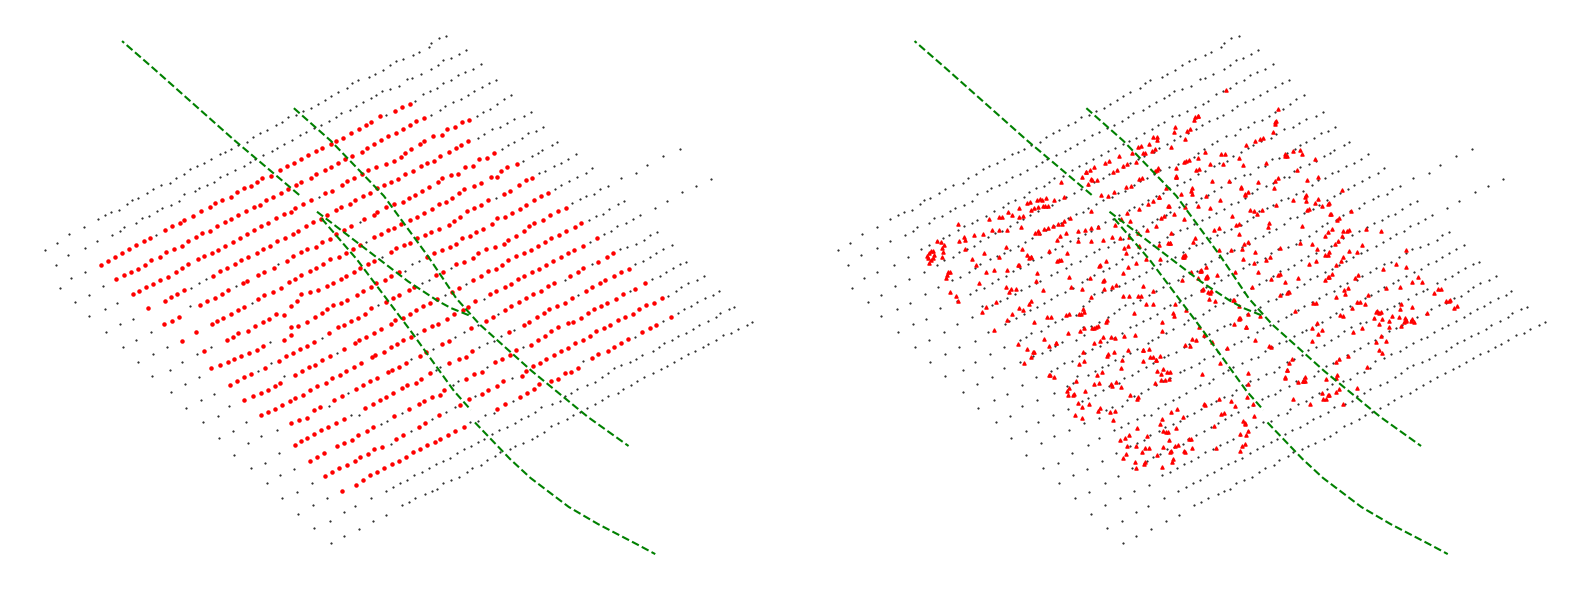

In [298]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
ax.scatter(lon_target_accept, lat_target_accept,marker='.',color='r',s=20)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'g--')
ax.axis('off')
    
ax = fig.add_subplot(122)
ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'g--')
for key_subwork in stations_accept_all_new.keys():
    ax.scatter(lon_centroid_all_new[key_subwork],lat_centroid_all_new[key_subwork],c='r',marker='^',s=5)
ax.axis('off')
plt.tight_layout()
plt.savefig(dir_image + 'station_distribution.png')

In [299]:
key_probe = {}
key_probe_accept = {}
for key_subwork in stations_accept_all_new.keys():
    key_target = key_subwork[:key_subwork.find('--')]
    probes_this = extract_probes(key_target)
    key_probe[key_subwork] = probes_this
    key_probe_accept[key_subwork] = probe_accept_all[key_target]
info_basic_bi['probe'] = key_probe
info_basic_bi['probe_accept'] = key_probe_accept

### Save to new subworks

In [300]:
# 将key的坐标写入excel
filename = dir_project+'stations_info.xlsx'
if os.path.exists(filename):
    os.remove(filename)
df=pd.DataFrame()
df['key_subwork'] = list(stations_accept_all_new.keys())
df['lon_centroid'] = list(lon_centroid_all_new.values())
df['lat_centroid'] = list(lat_centroid_all_new.values())
#写入excel的"location"sheet中
df.to_excel(filename,sheet_name='location',index=False)

In [301]:
books = load_workbook(filename)
writers = pd.ExcelWriter(filename, engine='openpyxl')
#writers.book = books

for key in stations_accept_all_new.keys():
    df=pd.DataFrame()
    df['Station'] = list(stations_accept_all_new[key])
    df['latitude'] = [lat_all[stalist_all.index(station)] for station in stations_accept_all_new[key]]
    df['longitude'] = [lon_all[stalist_all.index(station)] for station in stations_accept_all_new[key]]
    df.to_excel(writers, sheet_name=key,index=False)
writers._save()

In [302]:
filename = dir_project + 'subwork_location.xlsx'
df=pd.DataFrame()
df['key_subwork'] = [str(key_subwork) for key_subwork in key_subworks]
df['lon_centroid'] = list(lon_centroid_all.values())
df['lat_centroid'] = list(lat_centroid_all.values())
df.to_excel(filename,sheet_name='location',index=False)

In [303]:
info_basic['key_subworks'] = list(stations_accept_all_new.keys())
info_basic['stalistname_all'] = info_basic_probes['stalistname_all']
info_basic['stalistname'] = 'stations_info.xlsx'
info_basic['flag_f'] = flag_f
info_basic['flag_c'] = flag_c

In [304]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)
np.save(dir_project + 'Basic_info.npy', info_basic_bi)